In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd  #requirement comes with anaconda
import datetime 
import seaborn as sns
import operator
import numpy as np
import geopandas as gp #might need to install separately.
import sys
sys.path.insert(0,'../')
%load_ext autoreload
%autoreload 2
from utils import citibike_helpers
import networkx as nx

In [2]:
inputfile="../datasets/citibike/201701-citibike-tripdata.csv.gz"
df=citibike_helpers.load_citibike_data(inputfile)
df.head(2)

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226,W 82 St & Central Park West,40.782750,-73.971370,3165,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,Cooper Square & E 7 St,40.729236,-73.990868,498,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2


In [3]:
unique_start_stations=citibike_helpers.get_unique_column_values(df,'Start Station ID')
unique_end_stations=citibike_helpers.get_unique_column_values(df,'End Station ID')
station_ids=set(unique_start_stations).union(set(unique_end_stations))
print(unique_start_stations.shape)
print(unique_end_stations.shape)
print("Stations that no one ever starts at but they only end at",set(unique_end_stations).difference(set(unique_start_stations)))

(609,)
(612,)
Stations that no one ever starts at but they only end at {3250, 3447, 3183}


In [4]:
geo_stations=citibike_helpers.create_geodf_citibike_nyc(df,station_ids)
geo_stations.head(2)

,index,geometry,station_ids
0,0,POINT (-73.99392888 40.76727216),72
1,1,POINT (-74.00666661 40.71911552),79


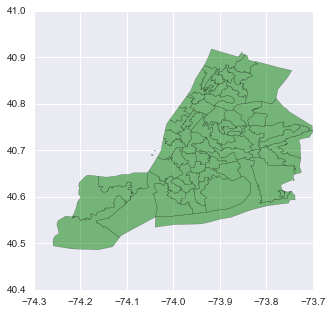

In [5]:
shp_nyc = gp.GeoDataFrame.from_file('../datasets/citibike/nyc_shapefiles/nyadwi.shp')
shp_nyc=shp_nyc.to_crs({'init':'epsg:4326'})
shp_nyc.plot(figsize=(5,5),color='g',alpha=0.5)

In [6]:
geo_stations.head(2)

,index,geometry,station_ids
0,0,POINT (-73.99392888 40.76727216),72
1,1,POINT (-74.00666661 40.71911552),79


In [7]:
class BoundingBox(object):
    """
    A 2D bounding box
    """
    def __init__(self, points):
        if len(points) == 0:
            raise ValueError("Can't compute bounding box of empty list")
        self.minx, self.miny = float("inf"), float("inf")
        self.maxx, self.maxy = float("-inf"), float("-inf")
        for x, y in points:
            # Set min coords
            if x < self.minx:
                self.minx = x
            if y < self.miny:
                self.miny = y
            # Set max coords
            if x > self.maxx:
                self.maxx = x
            elif y > self.maxy:
                self.maxy = y
    @property
    def width(self):
        return self.maxx - self.minx
    @property
    def height(self):
        return self.maxy - self.miny
    def __repr__(self):
        return "BoundingBox({}, {}, {}, {})".format(
            self.minx, self.maxx, self.miny, self.maxy)

In [ ]:
#westlimit=-74.020386; southlimit=40.701333; eastlimit=-73.957901; northlimit=40.807963

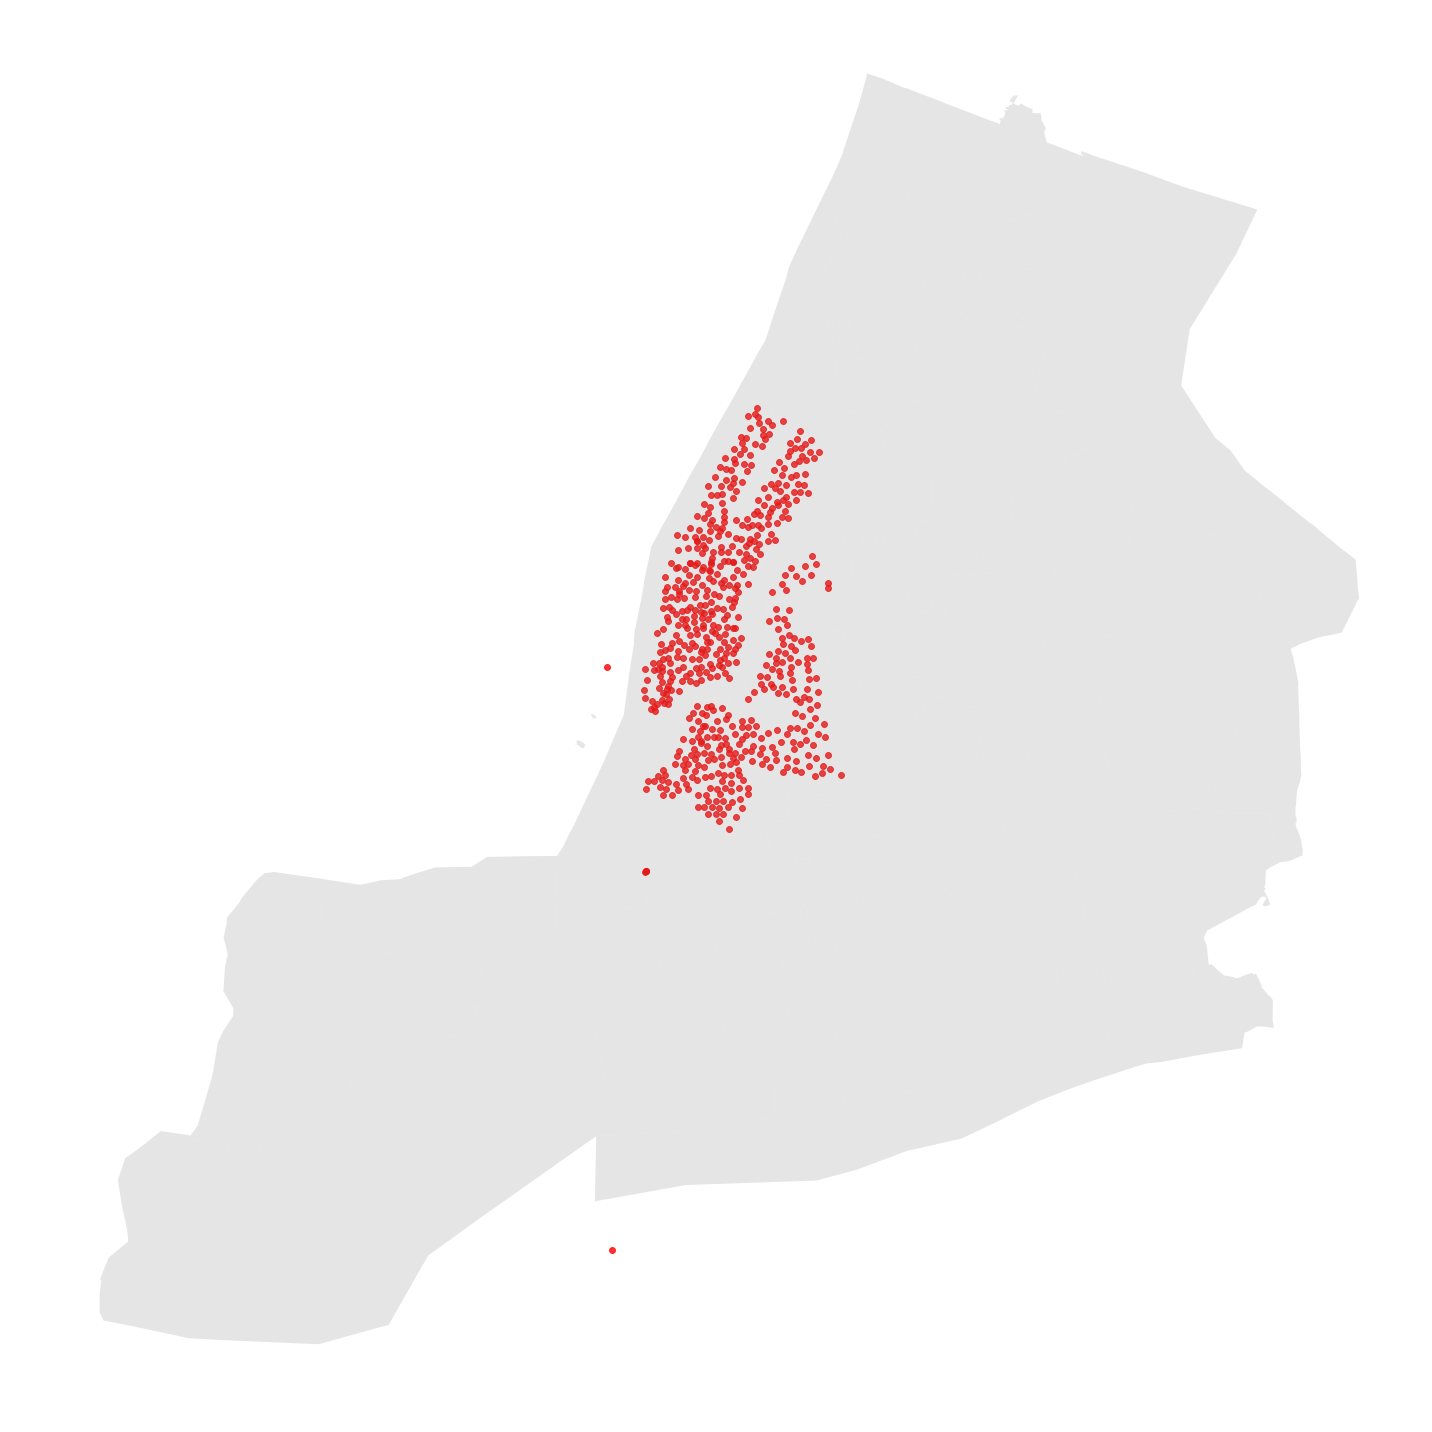

In [7]:
plt.style.use("default")
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(20,20))
base = shp_nyc.plot(ax=ax, color='gray', alpha=0.2)
#print(geo_stations)
geo_stations.plot(ax=base, marker="o", color="r", markersize=35,alpha=0.8, zorder=0)
_ = ax.axis('off')
#ax.set_title("Plot of Citibike Stations in NYC")
fig.tight_layout()
fig.savefig("nyc_citibike_stations.pdf")

# Inferring a Station-Station Network Using NetworkX

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd  #requirement comes with anaconda
import datetime 
from datetime import datetime as dt
import seaborn as sns
import operator
import networkx as nx

In [9]:
inputfile="../datasets/citibike/201701-citibike-tripdata.csv.gz"
df = citibike_helpers.load_citibike_data(inputfile)
df = citibike_helpers.calculate_trip_durations_citibike(df)
#Here we focus on a subset of "interesting" trips with duration between 5 and 120 minutes.
subset_trips=df[(df['Trip Duration Minutes']>5) & (df['Trip Duration Minutes']<120)]

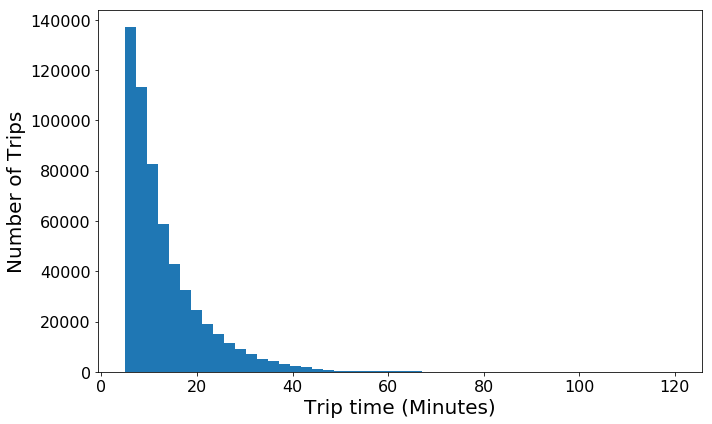

In [10]:
#Trips greater than 5 minutes and less than 2 hours. Triptime distribution.
fig,ax=plt.subplots(1,1,figsize=(10,6))
subset_trips['Trip Duration Minutes'].plot(ax=ax,kind='hist',bins=50,fontsize=16)
ax.set_xlabel('Trip time (Minutes)',fontsize=20)
ax.set_ylabel('Number of Trips',fontsize=20)
fig.tight_layout()
fig.savefig("figures/trip_duration_minutes.pdf")

# Plot Network Using NetworkX , Gephi

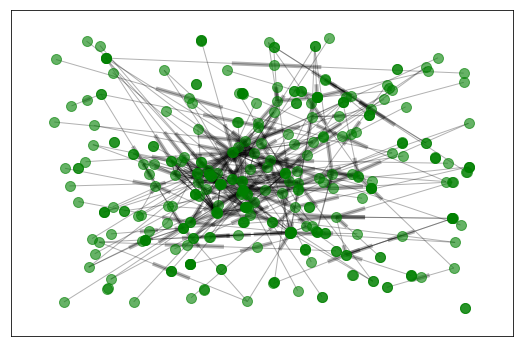

In [11]:
edges_with_weights=citibike_helpers.infer_weighted_station_station_network(subset_trips)
_thr=0.005
g=citibike_helpers.create_subset_graph(edges_with_weights,thr=_thr,graphtype='Directed')
fig_path="figures/citibike_top_"+str(_thr*100)+"_stn_stn_network.png"
citibike_helpers.plot_network(g,title="",edgealpha=0.3,node_dist=0.00001,nodesize=100,savefig=True,filename=fig_path)

In [12]:
nx.write_gexf(g,"misc/citibike_trip_graph.gexf")

### Strongly And Weakly Connected Components

Number of Strongly Connected Components 260 
Sample Strongly Connected Components [[450], [517], [513, 3141, 519, 359, 520, 490, 491, 492, 527, 402, 498, 379, 2012, 477]]


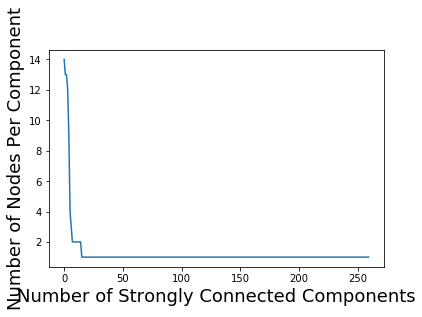

In [13]:
edges_with_weights=citibike_helpers.infer_weighted_station_station_network(subset_trips)
_thr=0.005
g=citibike_helpers.create_subset_graph(edges_with_weights,thr=_thr,graphtype='Directed')

#Strongly Connected Components    
scc=[list(l) for l in nx.strongly_connected_components(g)]  #Strongly Connected Components
print("Number of Strongly Connected Components",len(scc),"\nSample Strongly Connected Components",scc[:3])
plt.plot(list(sorted(map(lambda x: len(x),scc),reverse=True)))
plt.xlabel("Number of Strongly Connected Components",fontsize=18)
plt.ylabel("Number of Nodes Per Component",fontsize=18)

Number of Weakly Connected Components 17 
Sample Weakly Connected Components [[513, 514, 515, 3074, 517, 518, 519, 520, 3080, 522, 523, 3086, 527, 3087, 529, 530, 3091, 3090, 533, 534, 3092, 536, 3096, 3058, 539, 3100, 3093, 311, 546, 3106, 3108, 3109, 3110, 3107, 3112, 3113, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3135, 3136, 3137, 3140, 3141, 3142, 3143, 72, 319, 3150, 3151, 3156, 322, 3160, 3161, 3163, 3165, 3166, 3167, 3168, 3178, 3180, 531, 119, 127, 128, 143, 3219, 147, 3221, 3230, 3232, 3236, 164, 3237, 3240, 168, 3241, 3242, 3244, 173, 3246, 3393, 3255, 3256, 3263, 195, 3282, 212, 3288, 217, 3290, 216, 3292, 3294, 3295, 225, 3297, 3300, 229, 232, 3305, 3307, 236, 3308, 3310, 239, 3312, 241, 3314, 242, 3315, 244, 3319, 248, 3320, 3321, 3323, 3325, 3327, 255, 3330, 3331, 259, 3333, 261, 3336, 268, 3341, 3340, 3342, 3344, 270, 3347, 3348, 3349, 278, 279, 3352, 281, 3353, 282, 3354, 289, 3363, 291, 3367, 295, 296, 3368, 3372, 3373, 

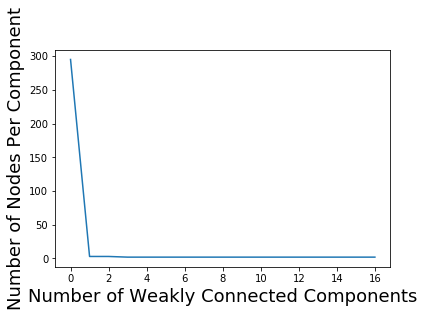

In [14]:
# Weakly Connected Components
wcc=[list(l) for l in nx.weakly_connected_components(g)]  #Strongly Connected Components
print("Number of Weakly Connected Components",len(wcc),"\nSample Weakly Connected Components",wcc[:3])
plt.plot(list(sorted(map(lambda x: len(x),wcc),reverse=True)))
plt.xlabel("Number of Weakly Connected Components",fontsize=18)
plt.ylabel("Number of Nodes Per Component",fontsize=18)

### Plot Degree Distribution

In [15]:
edges_with_weights=citibike_helpers.infer_weighted_station_station_network(subset_trips)
_thr=0.005
g=citibike_helpers.create_subset_graph(edges_with_weights,thr=_thr,graphtype='Directed')
node_indegrees,node_outdegrees=citibike_helpers.get_indegree_and_outdegree(g)
sorted_indegrees=citibike_helpers.sort_by_degree(node_indegrees,reverse=True)
sorted_outdegrees=citibike_helpers.sort_by_degree(node_outdegrees,reverse=True)

print("Sample Indegree List",node_indegrees[:5],"\n")
print("Sorted In Decreasing Order of Indegrees",sorted_indegrees[:5],"\n")
print("Sample Outdegree List",node_outdegrees[:5],"\n")
print("Sorted In Decreasing Order of Outdegree",sorted_outdegrees[:5],"\n")

Sample Indegree List [(3240, 0), (519, 30), (321, 0), (387, 6), (2006, 11)] 

Sorted In Decreasing Order of Indegrees [(519, 30), (2006, 11), (3374, 10), (3119, 10), (3141, 10)] 

Sample Outdegree List [(3240, 3), (519, 7), (321, 1), (387, 2), (2006, 8)] 

Sorted In Decreasing Order of Outdegree [(2006, 8), (3374, 8), (3119, 8), (426, 8), (519, 7)] 



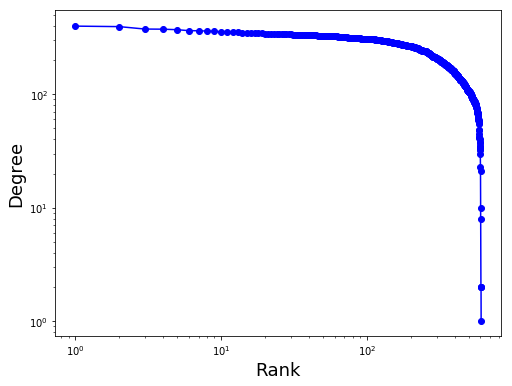

In [16]:
citibike_helpers.generate_degree_rank_plot(edges_with_weights)

# Clustering Coefficient

Average Clustering Coefficient 0.6093733890698344


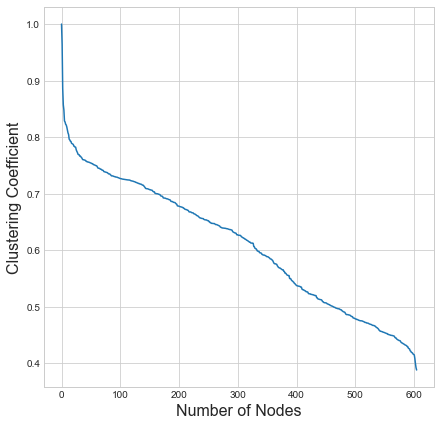

In [17]:
edges_with_weights=citibike_helpers.infer_weighted_station_station_network(subset_trips)
_thr=1.0
g=citibike_helpers.create_subset_graph(edges_with_weights,thr=_thr,graphtype='UnDirected')    
citibike_helpers.generate_clustering_coefficient_plot(g)
print("Average Clustering Coefficient",nx.average_clustering(g))

# Node Centric Community Detection

In [18]:
#Create Minimal Subgraph
edges_with_weights=citibike_helpers.infer_weighted_station_station_network(subset_trips)
_thr=0.005
g=citibike_helpers.create_subset_graph(edges_with_weights,thr=_thr,graphtype='UnDirected')

In [19]:
cl=nx.enumerate_all_cliques(g)
#print last 10 cliques
print([l for l in cl][-10:])

[[3282, 3374, 281, 3165], [3282, 3374, 3165, 3295], [3374, 3160, 281, 3143], [3374, 281, 3165, 3143], [2006, 3282, 3374, 3160, 281], [2006, 3282, 3374, 281, 3168], [2006, 3282, 3374, 281, 3165], [2006, 3282, 3374, 3165, 3295], [2006, 3374, 3160, 281, 3143], [2006, 3374, 281, 3165, 3143]]


In [20]:
print("5 Largest Cliques",sorted([l for l in nx.find_cliques(g)],key=lambda x: len(x),reverse=True)[:5])

5 Largest Cliques [[281, 3374, 2006, 3282, 3168], [281, 3374, 2006, 3282, 3160], [281, 3374, 2006, 3282, 3165], [281, 3374, 2006, 3143, 3160], [281, 3374, 2006, 3143, 3165]]


In [21]:
#Find Cliques containing Node ID 3143
print(nx.cliques_containing_node(g,3143))

[[281, 3374, 2006, 3143, 3160], [281, 3374, 2006, 3143, 3165]]


In [22]:
#Find K cliques using percolation method. K=4
print([l for l in nx.k_clique_communities(g,4)])

[frozenset({3168, 3137, 3320, 3143, 3374, 3282, 2006, 3160, 281, 3292, 3165, 3295})]


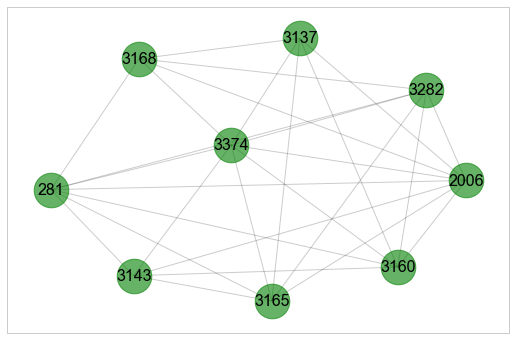

In [23]:
g_k=nx.k_core(g,k=5)
citibike_helpers.plot_network(g_k,node_dist=1.5,nodelabels=True)

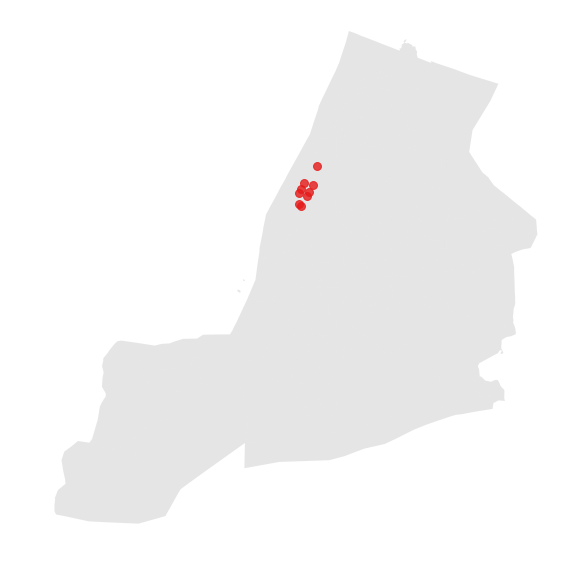

In [24]:
#Code to generate the shape file and station k_core visualization.
labels=g_k.nodes()
fig, ax = plt.subplots(1,1,figsize=(8,8))
base = shp_nyc.plot(ax=ax, color='gray', alpha=0.2)
geo_stations[geo_stations.station_ids.isin(labels)].plot(ax=base, marker="o", color="r", markersize=63,alpha=0.8, zorder=0)
_ = ax.axis('off')
fig.tight_layout()
fig.savefig("figures/nyc_citibike_k_core_stations.pdf")

# PAGERANK and HITS

In [25]:
#Create Minimal Subgraph
edges_with_weights=citibike_helpers.infer_weighted_station_station_network(subset_trips)
_thr=0.05
g=citibike_helpers.create_subset_graph(edges_with_weights,thr=_thr,graphtype='Directed')

In [26]:
pg_rank=sorted([l for l in nx.pagerank(g).items()],key=lambda x: x[1],reverse=True)
print("Top 10 Stations By Pagerank",pg_rank[:10])

Top 10 Stations By Pagerank [(519, 0.04771345937722662), (402, 0.017090924394493185), (523, 0.016538832671165255), (477, 0.015488475961843655), (379, 0.01546973906112217), (492, 0.01503096324617993), (520, 0.01281555268321768), (497, 0.012628852110425397), (490, 0.012309058900609474), (426, 0.011328346505475052)]


In [27]:
hubs,authorities=nx.hits(g)
hubs=sorted([l for l in hubs.items()],key=lambda x: x[1],reverse=True)
authorities=sorted([l for l in authorities.items()],key=lambda x: x[1],reverse=True)
print("Top 10 Biggest Hubs",hubs[:10])
print("\nTop 10 Biggest Authorities",authorities[:10])

Top 10 Biggest Hubs [(3240, 0.021284500190812614), (2006, 0.020678373669053226), (3374, 0.01832219153273398), (3160, 0.01622715253524153), (3165, 0.01525704756559378), (3282, 0.015002683272825664), (281, 0.013942693362901565), (3168, 0.012989342608604355), (3137, 0.010542623528872766), (490, 0.010094713516722071)]

Top 10 Biggest Authorities [(519, 0.06106950459242042), (2006, 0.03695788117007215), (3374, 0.0264378726398777), (520, 0.023632063962806874), (281, 0.022072063228290053), (3282, 0.021317036286654528), (3165, 0.01889005137342047), (499, 0.018081244177862884), (3168, 0.01758073331654557), (3137, 0.015386422733488078)]


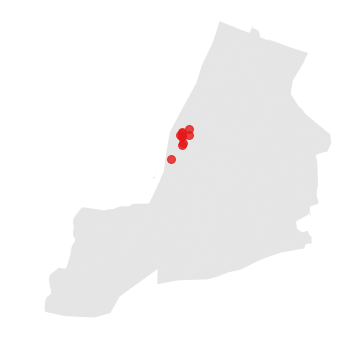

In [28]:
#Code to generate the shape file and station k_core visualization.
labels=list(map(lambda x: x[0],pg_rank[:10]))
fig, ax = plt.subplots(1,1,figsize=(5,5))
base = shp_nyc.plot(ax=ax, color='gray', alpha=0.2)
geo_stations[geo_stations.station_ids.isin(labels)].plot(ax=base, marker="o", color="r", markersize=63,alpha=0.8, zorder=0)
_ = ax.axis('off')
fig.tight_layout()
fig.savefig("figures/nyc_citibike_page_rank_top10_stations.pdf")

# Network to Line Graph 

Edge Labels {('J2', 'J1'): 'A', ('J4', 'J1'): 'C', ('J1', 'J4'): 'C', ('J4', 'J5'): 'F', ('J5', 'J4'): 'F', ('J2', 'J5'): 'D', ('J2', 'J3'): 'B', ('J3', 'J2'): 'B', ('J3', 'J6'): 'E', ('J6', 'J3'): 'E', ('J5', 'J6'): 'G', ('J6', 'J5'): 'G'}


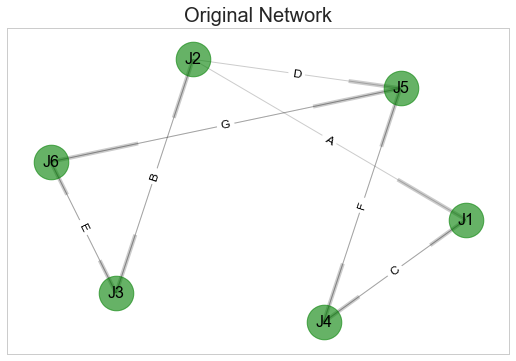

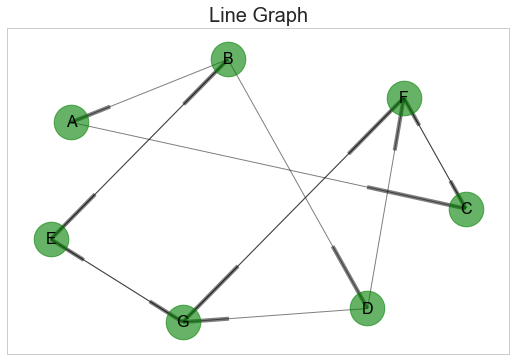

In [29]:
edges=[('J2','J1'),('J4','J1'),('J1','J4'),('J4','J5'),('J5','J4'),('J2','J5'),('J2','J3'),('J3','J2'),
       ('J3','J6'),('J6','J3'),('J5','J6'),('J6','J5')]
labels=['A','C','C','F','F','D','B','B','E','E','G','G']

g,edge_labels=citibike_helpers.generate_directed_network(edges,labels)
print("Edge Labels",edge_labels)
citibike_helpers.plot_network(g,node_dist=10,nodelabels=True,edgelabels=edge_labels,title='Original Network')
g2=citibike_helpers.generate_line_graph(edge_labels,g)
citibike_helpers.plot_network(g2,node_dist=10,edgealpha=0.5,nodelabels=True,title='Line Graph')